# Probing GIN on BA2_GRID_HOUSE dataset

In [1]:
# PyTorch and PyTorch Geometric imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import torch_geometric.utils as pyg_utils
from torch_geometric.utils import from_networkx

# NetworkX imports
import networkx as nx
from networkx.algorithms.centrality import betweenness_centrality

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression

# Other imports
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import random

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
torch.cuda.is_available()

False

In [4]:
def set_seed(seed):
    if seed == -1:
        seed = random.randint(0, 1000)
    # Pandas also uses np random state by default
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

    # if you are using GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
set_seed(37)

Model

In [6]:
MODEL = "GIN4"
DATASET = "BA_2grid_house_no_isomorphic"

# import the model
from models.models_BA_2grid_house import GIN_framework4 as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house_no_isomorphic

In [7]:
# inizialize the framework
dataset = BA_2grid_house_no_isomorphic()
gnn = framework(dataset) #,device="cpu")

c:\Users\tomdu\miniconda3\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [8]:
#dataset length
len(dataset)

1987

In [9]:
# the gnn object contains the train test split and the model.

print(gnn.model)
print(gnn.train_idx)
print(gnn.dataset[gnn.train_idx])

Net(
  (mlp1): Linear(in_features=10, out_features=30, bias=True)
  (conv1): GINConv(nn=Linear(in_features=10, out_features=30, bias=True))
  (mlp2): Linear(in_features=30, out_features=30, bias=True)
  (conv2): GINConv(nn=Linear(in_features=30, out_features=30, bias=True))
  (mlp3): Linear(in_features=30, out_features=30, bias=True)
  (conv3): GINConv(nn=Linear(in_features=30, out_features=30, bias=True))
  (lin1): Linear(in_features=30, out_features=30, bias=True)
  (lin2): Linear(in_features=30, out_features=2, bias=True)
)
tensor([1645,  622,  931,  ...,  788, 1892,  569])
BA_2grid_house_no_isomorphic(1589)


In [10]:
# gnn.iterate()

In [11]:
# gnn.save_model("models/"+DATASET+"_"+MODEL)

In [12]:
#now that the model is instaziated, we have to load the weights
gnn.load_model("models/"+DATASET+"_"+MODEL) #, map_location='cpu')
print("we loaded the weights")
# right now the model has trained weights.
#print(gnn.model.mlp1.weight[0])

we loaded the weights


In [13]:
# train the model
gnn.evaluate()

Test Loss: 0.000, Train Acc: 1.000 Test Acc: 1.000


Properties of the graphs

In [14]:
def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_nodes_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        # small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_nodes_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

#save the properties in a file
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
    pkl.dump(train_properties, f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
    pkl.dump(test_properties, f)

In [15]:
print(train_properties[0:3])
print(test_properties[0:3])

[(25, 30, 0.1, 4.086666666666667, 28, 1.0, 0.8232142857142858, 25), (27, 32, 0.09116809116809117, 4.626780626780627, 30, 1.0, 0.8051587301587302, 27), (27, 32, 0.09116809116809117, 4.347578347578348, 30, 1.0, 0.7524891774891775, 27)]
[(26, 31, 0.09538461538461539, 4.541538461538462, 29, 1.0, 0.7575396825396825, 26), (26, 31, 0.09538461538461539, 4.406153846153846, 29, 1.0, 0.8107142857142858, 26), (27, 28, 0.07977207977207977, 3.561253561253561, 26, 1.0, 0.2648809523809524, 27)]


In [16]:
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties_special.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties_special.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

In [13]:
#open the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

### Probing pipeline 

from extracting features to training a diagnostic classifier

In [14]:
"""
train_features and test_features are lists of lists. Each element correspond to a graph, each graph has 4 layers of features, and each features has a shape of (num_nodes, num_features) where each row is a node and each column is a feature. 
To probe our model we will use the four different layers and probe for node properties based on their corresponding row in the feature matrix.
"""
train_features, test_features = gnn.evaluate_with_features2()

In [ ]:
# Function to calculate the norm of each node feature and reindex the graph embedding for all layers of all graphs
def reindex_graph_embeddings(features):
    reindexed_features = []
    for graph_features in features:
        reindexed_graph = []
        for layer_features in graph_features:
            # Convert to torch tensor
            layer_tensor = torch.tensor(layer_features, dtype=torch.float32)
            # Compute the norm of the layer features
            norms = torch.norm(layer_tensor, dim=1)
            # Sort the norms in descending order and get the indices
            norm, indices = norms.sort(descending=True)
            # Reindex the layer features based on the sorted indices
            sorted_embedding = layer_tensor.index_select(0, indices)
            reindexed_graph.append(sorted_embedding)
        reindexed_features.append(reindexed_graph)
    return reindexed_features

# Reindex train and test features
train_features = reindex_graph_embeddings(train_features)
test_features = reindex_graph_embeddings(test_features)

# Print the reindexed features for the first graph in train_features
print(train_features[0])

[tensor([[0.0000, 0.0000, 0.1759,  ..., 0.1694, 0.0000, 0.0750],
        [0.0000, 0.0000, 0.1587,  ..., 0.1571, 0.0000, 0.0616],
        [0.0000, 0.0000, 0.1534,  ..., 0.1533, 0.0000, 0.0574],
        ...,
        [0.0000, 0.0000, 0.1062,  ..., 0.1194, 0.0000, 0.0205],
        [0.0000, 0.0000, 0.1001,  ..., 0.1150, 0.0000, 0.0158],
        [0.0000, 0.0000, 0.1001,  ..., 0.1150, 0.0000, 0.0158]]), tensor([[0.0000, 0.0000, 0.0536,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0531,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0559,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0

In [28]:
print(len(train_features), len(test_features))
print(len(train_features[0]))
print(train_features[0][0].shape)

1589 398
6
(23, 30)


In [19]:
# Check the shape of each feature
for i, feat in enumerate(train_features):
    print(f"Train feature {i} shape: {[f.shape for f in feat]}")

for i, feat in enumerate(test_features):
    print(f"Test feature {i} shape: {[f.shape for f in feat]}")
    
    
# Determine the maximum length for the first five elements
max_length = max(max(f.shape[0] for f in feat[:5]) for feat in train_features + test_features)

# Pad the features
def pad_features(features, max_length):
    padded_features = []
    for feat in features:
        padded_feat = []
        for f in feat[:3]:
            padded_f = np.pad(f, ((0, max_length - f.shape[0]), (0, 0)), mode='constant')
            padded_feat.append(padded_f)
        padded_feat.extend(feat[3:])  # Append the last three elements as they are
        padded_features.append(padded_feat)
    return padded_features

# Pad train and test features
train_features = pad_features(train_features, max_length)
test_features = pad_features(test_features, max_length)

# Check the shape of each feature
for i, feat in enumerate(train_features):
    print(f"Train feature {i} shape: {[f.shape for f in feat]}")

for i, feat in enumerate(test_features):
    print(f"Test feature {i} shape: {[f.shape for f in feat]}")

Train feature 0 shape: [(23, 30), (23, 30), (23, 30), (1, 30), (1, 30), (1, 2)]
Train feature 1 shape: [(20, 30), (20, 30), (20, 30), (1, 30), (1, 30), (1, 2)]
Train feature 2 shape: [(23, 30), (23, 30), (23, 30), (1, 30), (1, 30), (1, 2)]
Train feature 3 shape: [(21, 30), (21, 30), (21, 30), (1, 30), (1, 30), (1, 2)]
Train feature 4 shape: [(20, 30), (20, 30), (20, 30), (1, 30), (1, 30), (1, 2)]
Train feature 5 shape: [(20, 30), (20, 30), (20, 30), (1, 30), (1, 30), (1, 2)]
Train feature 6 shape: [(29, 30), (29, 30), (29, 30), (1, 30), (1, 30), (1, 2)]
Train feature 7 shape: [(22, 30), (22, 30), (22, 30), (1, 30), (1, 30), (1, 2)]
Train feature 8 shape: [(20, 30), (20, 30), (20, 30), (1, 30), (1, 30), (1, 2)]
Train feature 9 shape: [(21, 30), (21, 30), (21, 30), (1, 30), (1, 30), (1, 2)]
Train feature 10 shape: [(25, 30), (25, 30), (25, 30), (1, 30), (1, 30), (1, 2)]
Train feature 11 shape: [(20, 30), (20, 30), (20, 30), (1, 30), (1, 30), (1, 2)]
Train feature 12 shape: [(20, 30), (20

C:\Users\tomdu\AppData\Local\Temp\ipykernel_18460\4282447330.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


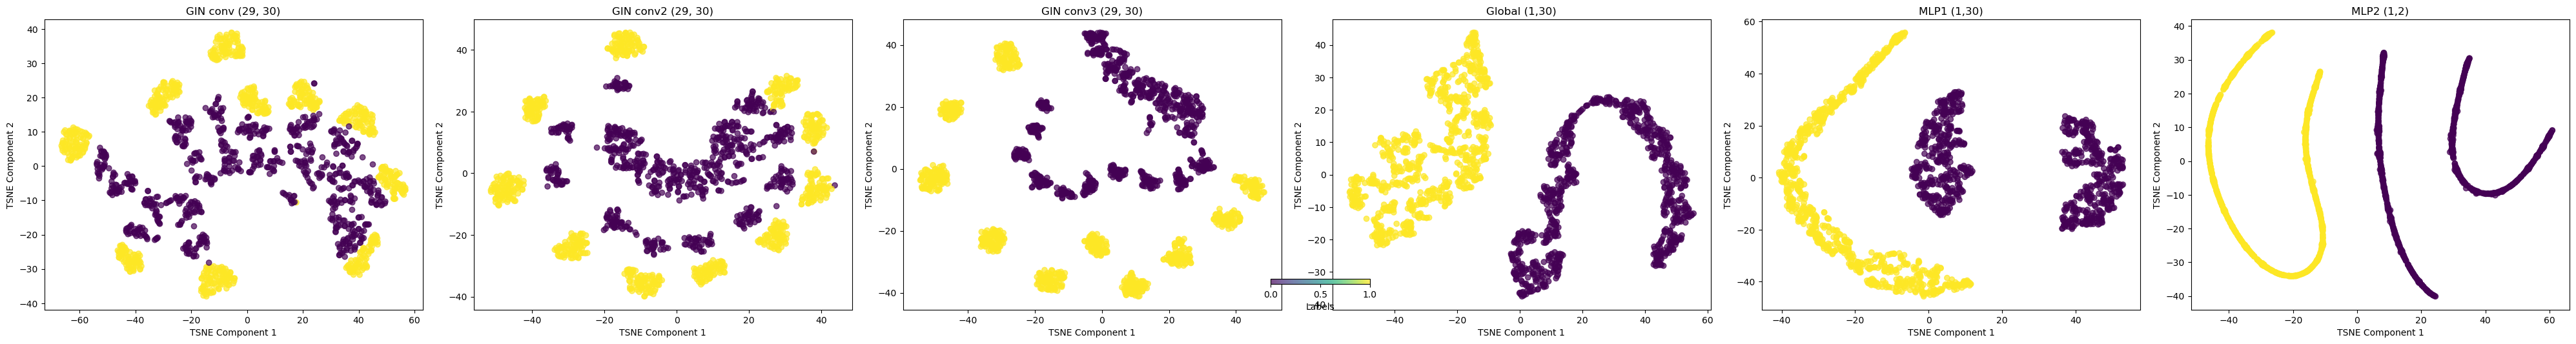

In [31]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

layers_names = ['GIN conv (29, 30)', 'GIN conv2 (29, 30)', 'GIN conv3 (29, 30)', 'Global (1,30)', 'MLP1 (1,30)', 'MLP2 (1,2)']

# Define a function to plot T-SNE for a given layer
def plot_tsne_for_layer(layer_idx, train_features, labels, ax):
    # Extract the embedding layer from train_features
    embedding_layer = [feat[layer_idx] for feat in train_features]

    # Flatten the embeddings
    flattened_embeddings = [embedding.flatten() for embedding in embedding_layer]

    # Convert to numpy array
    flattened_embeddings = np.array(flattened_embeddings)

    # Apply T-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(flattened_embeddings)

    # Plot the T-SNE results
    scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.7)
    ax.set_title(layers_names[layer_idx])
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    return scatter

# Get the labels
labels = gnn.dataset[gnn.train_idx].y.cpu().numpy()

# Create subplots
fig, axes = plt.subplots(1, 6, figsize=(40, 5))

# Plot T-SNE for layers 0 to 5
for layer_idx in range(6):
    scatter = plot_tsne_for_layer(layer_idx, train_features, labels, axes[layer_idx])

# Add a colorbar
cbar = fig.colorbar(scatter, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
cbar.set_label('Labels')

plt.tight_layout()
#save as pdf    
plt.savefig("results/"+DATASET+"_"+MODEL+"_tsne.pdf")

plt.show()

#### Diagnostic classifier

In [23]:
"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x_global, x5, x6)
"""

output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
# train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x_global = np.array([feat[3] for feat in train_features])
test_x_global = np.array([feat[3] for feat in test_features])

train_x5 = np.array([feat[4] for feat in train_features])
test_x5 = np.array([feat[4] for feat in test_features])

train_x6 = np.array([feat[5] for feat in train_features])
test_x6 = np.array([feat[5] for feat in test_features])


# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']#, 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
embeddings_names = ['x', 'x2', 'x3', 'x_global', 'x5', 'x6']

In [25]:
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    # Flatten the embeddings before determining the input size
    train_embedding_flat = train_embedding.view(train_embedding.size(0), -1)
    test_embedding_flat = test_embedding.view(test_embedding.size(0), -1)
    #print the shapes
    print(train_embedding_flat.shape)
    print(test_embedding_flat.shape)
    input_size = train_embedding_flat.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding_flat).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding_flat).squeeze().cpu().numpy()
            test_pred = model(test_embedding_flat).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save the results in a file
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

torch.Size([1589, 870])
torch.Size([398, 870])
Epoch [1000/10000], Property: num_nodes, Loss: 0.2035
Epoch [2000/10000], Property: num_nodes, Loss: 0.1367
Epoch [3000/10000], Property: num_nodes, Loss: 0.1037
Epoch [4000/10000], Property: num_nodes, Loss: 0.0769
Epoch [5000/10000], Property: num_nodes, Loss: 0.0552
Epoch [6000/10000], Property: num_nodes, Loss: 0.0370
Epoch [7000/10000], Property: num_nodes, Loss: 0.0231
Epoch [8000/10000], Property: num_nodes, Loss: 0.0143
Epoch [9000/10000], Property: num_nodes, Loss: 0.0094
Epoch [10000/10000], Property: num_nodes, Loss: 0.0063
Embedding: torch.Size([1589, 29, 30])
Property: num_nodes
  Train MSE: 0.0063, Test MSE: 0.0067
  Train R²: 0.9992, Test R²: 0.9992
Epoch [1000/10000], Property: num_edges, Loss: 3.5634
Epoch [2000/10000], Property: num_edges, Loss: 2.0354
Epoch [3000/10000], Property: num_edges, Loss: 1.0036
Epoch [4000/10000], Property: num_edges, Loss: 0.3995
Epoch [5000/10000], Property: num_edges, Loss: 0.1763
Epoch [600

In [ ]:
#load the results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

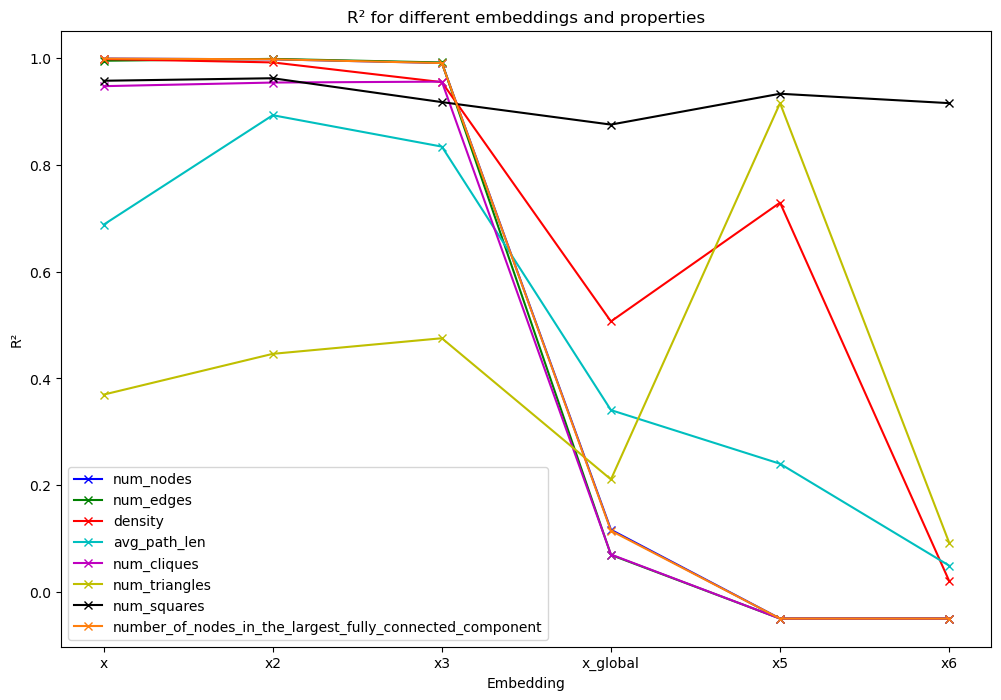

In [33]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component'] #, 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
embeddings_names = ['x', 'x2', 'x3',  'x_global', 'x5', 'x6', ]
# embeddings = [(train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
# embeddings_names = ['x_global', 'x5', 'x6']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
#put the legend on the right side of the plot
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#save in svg
plt.savefig("results/"+DATASET+"_"+MODEL+"_R2_all_layers.svg", format='svg', bbox_inches='tight')

plt.show()

#### Post pooling probing

In [18]:
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
embeddings_names = ['x_global', 'x5', 'x6']

#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save the results in a file
with open("results/"+DATASET+"_"+MODEL+"_results_wo-prepooling.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/10000], Property: num_nodes, Loss: 102.0932
Epoch [2000/10000], Property: num_nodes, Loss: 13.1460
Epoch [3000/10000], Property: num_nodes, Loss: 8.6570
Epoch [4000/10000], Property: num_nodes, Loss: 8.4649
Epoch [5000/10000], Property: num_nodes, Loss: 8.2764
Epoch [6000/10000], Property: num_nodes, Loss: 8.1050
Epoch [7000/10000], Property: num_nodes, Loss: 7.9688
Epoch [8000/10000], Property: num_nodes, Loss: 7.8545
Epoch [9000/10000], Property: num_nodes, Loss: 7.7525
Epoch [10000/10000], Property: num_nodes, Loss: 7.6705
Embedding: torch.Size([1589, 30])
Property: num_nodes
  Train MSE: 7.6704, Test MSE: 7.3479
  Train R²: 0.0575, Test R²: 0.1178
Epoch [1000/10000], Property: num_edges, Loss: 178.5174
Epoch [2000/10000], Property: num_edges, Loss: 25.8588
Epoch [3000/10000], Property: num_edges, Loss: 11.1506
Epoch [4000/10000], Property: num_edges, Loss: 10.7476
Epoch [5000/10000], Property: num_edges, Loss: 10.5676
Epoch [6000/10000], Property: num_edges, Loss: 10.39

In [14]:
#load the results
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)

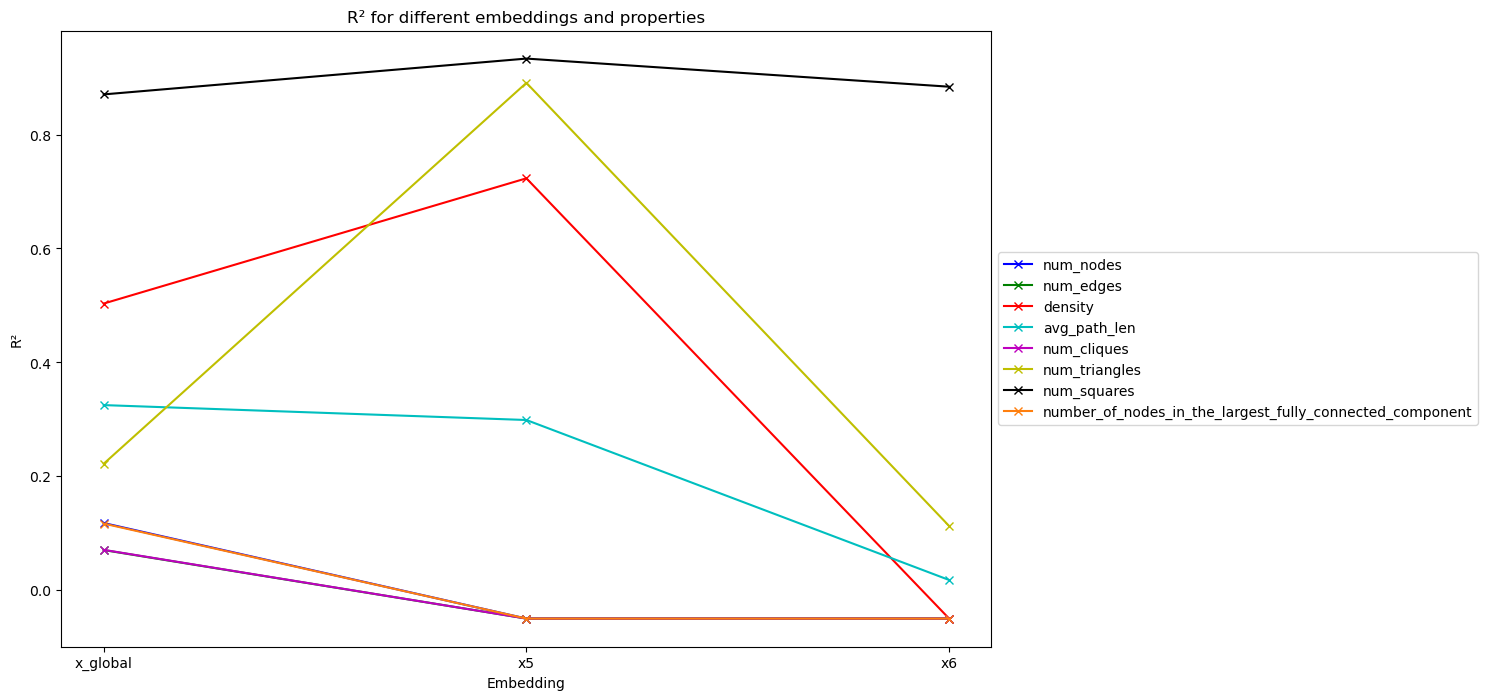

In [22]:
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component'] #, 'small_world']
# embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
# embeddings_names = ['x', 'x2', 'x3',  'x_global', 'x5', 'x6', ]
embeddings = [(train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
embeddings_names = ['x_global', 'x5', 'x6']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
#put the legend on the right side of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#save in svg
plt.savefig("results/"+DATASET+"_"+MODEL+"_R2.svg", format='svg', bbox_inches='tight')

plt.show()

In [20]:
#print the resulst in a table (layers as rows, properties as columns)
import pandas as pd

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component'] #, 'small_world']
# embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
# embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']
embeddings = [(train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6)]
embeddings_names = ['x_global', 'x5', 'x6']

results_table = pd.DataFrame(index=embeddings_names, columns=property_names)

for i, property_name in enumerate(property_names):
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        results_table.loc[name_of_embedding, property_name] = test_r2

results_table

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,num_nodes,num_edges,density,avg_path_len,num_cliques,num_triangles,num_squares,number_of_nodes_in_the_largest_fully_connected_component
x_global,0.117785,0.07034,0.503178,0.324881,0.070712,0.22185,0.870446,0.116829
x5,-0.682962,-0.798826,0.723106,0.29869,-0.574394,0.890717,0.933344,-0.675471
x6,-9.80401,-11.605268,-1.16111,0.017756,-6.555527,0.112557,0.883961,-4.001842


### comparison with a gnn train on random (the y are shuffled)

In [18]:
### comparison with a gnn train on random (the y are shuffled)

MODEL = "GCN"
DATASET = "BA_2grid_house_shuffled"

# import the model
from models.models_BA_2grid_house import GCN_framework as framework
# import the dataset
from Datasets.synthetics import BA_2grid_house_no_isomorphic


In [19]:
# inizialize the framework
dataset = BA_2grid_house_no_isomorphic()

In [20]:
dataset[0].y

tensor([0])

In [4]:

#shuffle the y values of the dataset
import numpy as np
import torch

y = np.array([data.y for data in dataset])
# Assuming y is a list or numpy array
y = np.array(y, dtype=np.int64)  # Ensure y is a numeric array of type int64

# Shuffle y
np.random.shuffle(y)

# Convert y to a PyTorch tensor with dtype torch.int64
y = torch.tensor(y, dtype=torch.int64)

# Update dataset with the new y values
for i in range(len(dataset)):
    dataset[i].y = y[i]


/scratch-local/tpelletreaudur.7482777/ipykernel_2250917/3974855861.py:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  y = np.array([data.y for data in dataset])
/scratch-local/tpelletreaudur.7482777/ipykernel_2250917/3974855861.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array([data.y for data in dataset])


In [5]:
dataset[0].y

tensor([0])

In [6]:
gnn = framework(dataset)

/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [7]:
gnn.iterate()

/home/tpelletreaudur/.local/lib/python3.10/site-packages/torch_geometric/warnings.py:11: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 0.699, Test Loss: 0.174, Train Acc: 0.500 Test Acc: 0.500
Epoch: 002, Loss: 0.697, Test Loss: 0.174, Train Acc: 0.500 Test Acc: 0.500
Epoch: 003, Loss: 0.695, Test Loss: 0.173, Train Acc: 0.500 Test Acc: 0.500
Epoch: 004, Loss: 0.693, Test Loss: 0.173, Train Acc: 0.500 Test Acc: 0.500
Epoch: 005, Loss: 0.691, Test Loss: 0.172, Train Acc: 0.535 Test Acc: 0.527
Epoch: 006, Loss: 0.688, Test Loss: 0.172, Train Acc: 0.500 Test Acc: 0.500
Epoch: 007, Loss: 0.687, Test Loss: 0.172, Train Acc: 0.500 Test Acc: 0.500
Epoch: 008, Loss: 0.686, Test Loss: 0.172, Train Acc: 0.500 Test Acc: 0.500
Epoch: 009, Loss: 0.685, Test Loss: 0.171, Train Acc: 0.500 Test Acc: 0.500
Epoch: 010, Loss: 0.684, Test Loss: 0.171, Train Acc: 0.500 Test Acc: 0.500
Epoch: 011, Loss: 0.682, Test Loss: 0.171, Train Acc: 0.500 Test Acc: 0.500
Epoch: 012, Loss: 0.681, Test Loss: 0.170, Train Acc: 0.500 Test Acc: 0.500
Epoch: 013, Loss: 0.679, Test Loss: 0.170, Train Acc: 0.506 Test Acc: 0.505
Epoch: 014, 

Epoch: 109, Loss: 0.519, Test Loss: 0.130, Train Acc: 0.769 Test Acc: 0.752
Epoch: 110, Loss: 0.518, Test Loss: 0.129, Train Acc: 0.770 Test Acc: 0.750
Epoch: 111, Loss: 0.517, Test Loss: 0.129, Train Acc: 0.772 Test Acc: 0.760
Epoch: 112, Loss: 0.516, Test Loss: 0.129, Train Acc: 0.774 Test Acc: 0.760
Epoch: 113, Loss: 0.514, Test Loss: 0.129, Train Acc: 0.776 Test Acc: 0.757
Epoch: 114, Loss: 0.514, Test Loss: 0.129, Train Acc: 0.773 Test Acc: 0.750
Epoch: 115, Loss: 0.516, Test Loss: 0.129, Train Acc: 0.772 Test Acc: 0.750
Epoch: 116, Loss: 0.518, Test Loss: 0.128, Train Acc: 0.774 Test Acc: 0.755
Epoch: 117, Loss: 0.517, Test Loss: 0.128, Train Acc: 0.777 Test Acc: 0.757
Epoch: 118, Loss: 0.513, Test Loss: 0.127, Train Acc: 0.776 Test Acc: 0.755
Epoch: 119, Loss: 0.511, Test Loss: 0.127, Train Acc: 0.777 Test Acc: 0.755
Epoch: 120, Loss: 0.509, Test Loss: 0.127, Train Acc: 0.779 Test Acc: 0.757
Epoch: 121, Loss: 0.508, Test Loss: 0.126, Train Acc: 0.779 Test Acc: 0.757
Epoch: 122, 

Epoch: 217, Loss: 0.446, Test Loss: 0.111, Train Acc: 0.793 Test Acc: 0.795
Epoch: 218, Loss: 0.446, Test Loss: 0.111, Train Acc: 0.793 Test Acc: 0.795
Epoch: 219, Loss: 0.446, Test Loss: 0.111, Train Acc: 0.792 Test Acc: 0.797
Epoch: 220, Loss: 0.446, Test Loss: 0.111, Train Acc: 0.792 Test Acc: 0.797
Epoch: 221, Loss: 0.445, Test Loss: 0.111, Train Acc: 0.791 Test Acc: 0.797
Epoch: 222, Loss: 0.445, Test Loss: 0.111, Train Acc: 0.792 Test Acc: 0.792
Epoch: 223, Loss: 0.445, Test Loss: 0.110, Train Acc: 0.792 Test Acc: 0.792
Epoch: 224, Loss: 0.445, Test Loss: 0.110, Train Acc: 0.792 Test Acc: 0.792
Epoch: 225, Loss: 0.445, Test Loss: 0.110, Train Acc: 0.792 Test Acc: 0.795
Epoch: 226, Loss: 0.444, Test Loss: 0.110, Train Acc: 0.793 Test Acc: 0.795
Epoch: 227, Loss: 0.444, Test Loss: 0.111, Train Acc: 0.792 Test Acc: 0.795
Epoch: 228, Loss: 0.443, Test Loss: 0.110, Train Acc: 0.792 Test Acc: 0.795
Epoch: 229, Loss: 0.443, Test Loss: 0.110, Train Acc: 0.794 Test Acc: 0.795
Epoch: 230, 

Epoch: 325, Loss: 0.427, Test Loss: 0.107, Train Acc: 0.794 Test Acc: 0.802
Epoch: 326, Loss: 0.427, Test Loss: 0.107, Train Acc: 0.796 Test Acc: 0.800
Epoch: 327, Loss: 0.427, Test Loss: 0.107, Train Acc: 0.796 Test Acc: 0.800
Epoch: 328, Loss: 0.427, Test Loss: 0.107, Train Acc: 0.794 Test Acc: 0.802
Epoch: 329, Loss: 0.427, Test Loss: 0.107, Train Acc: 0.795 Test Acc: 0.800
Epoch: 330, Loss: 0.427, Test Loss: 0.107, Train Acc: 0.795 Test Acc: 0.800
Epoch: 331, Loss: 0.427, Test Loss: 0.107, Train Acc: 0.795 Test Acc: 0.800
Epoch: 332, Loss: 0.426, Test Loss: 0.107, Train Acc: 0.796 Test Acc: 0.802
Epoch: 333, Loss: 0.426, Test Loss: 0.107, Train Acc: 0.796 Test Acc: 0.800
Epoch: 334, Loss: 0.426, Test Loss: 0.107, Train Acc: 0.796 Test Acc: 0.800
Epoch: 335, Loss: 0.426, Test Loss: 0.107, Train Acc: 0.794 Test Acc: 0.802
Epoch: 336, Loss: 0.426, Test Loss: 0.107, Train Acc: 0.796 Test Acc: 0.802
Epoch: 337, Loss: 0.426, Test Loss: 0.107, Train Acc: 0.795 Test Acc: 0.802
Epoch: 338, 

Epoch: 433, Loss: 0.420, Test Loss: 0.106, Train Acc: 0.798 Test Acc: 0.800
Epoch: 434, Loss: 0.420, Test Loss: 0.106, Train Acc: 0.799 Test Acc: 0.797
Epoch: 435, Loss: 0.420, Test Loss: 0.106, Train Acc: 0.799 Test Acc: 0.800
Epoch: 436, Loss: 0.420, Test Loss: 0.106, Train Acc: 0.798 Test Acc: 0.800
Epoch: 437, Loss: 0.420, Test Loss: 0.106, Train Acc: 0.797 Test Acc: 0.800
Epoch: 438, Loss: 0.420, Test Loss: 0.106, Train Acc: 0.799 Test Acc: 0.797
Epoch: 439, Loss: 0.419, Test Loss: 0.106, Train Acc: 0.797 Test Acc: 0.800
Epoch: 440, Loss: 0.420, Test Loss: 0.106, Train Acc: 0.798 Test Acc: 0.800
Epoch: 441, Loss: 0.419, Test Loss: 0.106, Train Acc: 0.798 Test Acc: 0.800
Epoch: 442, Loss: 0.419, Test Loss: 0.106, Train Acc: 0.799 Test Acc: 0.800
Epoch: 443, Loss: 0.419, Test Loss: 0.106, Train Acc: 0.798 Test Acc: 0.800
Epoch: 444, Loss: 0.419, Test Loss: 0.106, Train Acc: 0.797 Test Acc: 0.797
Epoch: 445, Loss: 0.419, Test Loss: 0.106, Train Acc: 0.799 Test Acc: 0.800
Epoch: 446, 

Epoch: 541, Loss: 0.416, Test Loss: 0.106, Train Acc: 0.805 Test Acc: 0.797
Epoch: 542, Loss: 0.416, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.797
Epoch: 543, Loss: 0.416, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.797
Epoch: 544, Loss: 0.416, Test Loss: 0.106, Train Acc: 0.805 Test Acc: 0.795
Epoch: 545, Loss: 0.415, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.795
Epoch: 546, Loss: 0.415, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.797
Epoch: 547, Loss: 0.416, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.797
Epoch: 548, Loss: 0.416, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.795
Epoch: 549, Loss: 0.415, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.795
Epoch: 550, Loss: 0.415, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.797
Epoch: 551, Loss: 0.415, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.795
Epoch: 552, Loss: 0.415, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.795
Epoch: 553, Loss: 0.415, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.797
Epoch: 554, 

Epoch: 649, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.807 Test Acc: 0.795
Epoch: 650, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.807 Test Acc: 0.795
Epoch: 651, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.808 Test Acc: 0.795
Epoch: 652, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.806 Test Acc: 0.795
Epoch: 653, Loss: 0.412, Test Loss: 0.106, Train Acc: 0.806 Test Acc: 0.795
Epoch: 654, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.808 Test Acc: 0.795
Epoch: 655, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.806 Test Acc: 0.795
Epoch: 656, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.806 Test Acc: 0.795
Epoch: 657, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.806 Test Acc: 0.795
Epoch: 658, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.807 Test Acc: 0.795
Epoch: 659, Loss: 0.411, Test Loss: 0.105, Train Acc: 0.808 Test Acc: 0.795
Epoch: 660, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.807 Test Acc: 0.795
Epoch: 661, Loss: 0.412, Test Loss: 0.105, Train Acc: 0.807 Test Acc: 0.795
Epoch: 662, 

Epoch: 757, Loss: 0.407, Test Loss: 0.105, Train Acc: 0.809 Test Acc: 0.782
Epoch: 758, Loss: 0.408, Test Loss: 0.105, Train Acc: 0.808 Test Acc: 0.782
Epoch: 759, Loss: 0.407, Test Loss: 0.105, Train Acc: 0.810 Test Acc: 0.785
Epoch: 760, Loss: 0.406, Test Loss: 0.105, Train Acc: 0.810 Test Acc: 0.785
Epoch: 761, Loss: 0.407, Test Loss: 0.105, Train Acc: 0.811 Test Acc: 0.785
Epoch: 762, Loss: 0.407, Test Loss: 0.105, Train Acc: 0.809 Test Acc: 0.785
Epoch: 763, Loss: 0.408, Test Loss: 0.104, Train Acc: 0.810 Test Acc: 0.790
Epoch: 764, Loss: 0.408, Test Loss: 0.105, Train Acc: 0.811 Test Acc: 0.782
Epoch: 765, Loss: 0.408, Test Loss: 0.106, Train Acc: 0.809 Test Acc: 0.787
Epoch: 766, Loss: 0.407, Test Loss: 0.105, Train Acc: 0.810 Test Acc: 0.787
Epoch: 767, Loss: 0.406, Test Loss: 0.105, Train Acc: 0.810 Test Acc: 0.785
Epoch: 768, Loss: 0.407, Test Loss: 0.105, Train Acc: 0.810 Test Acc: 0.787
Epoch: 769, Loss: 0.407, Test Loss: 0.105, Train Acc: 0.811 Test Acc: 0.782
Epoch: 770, 

Epoch: 865, Loss: 0.404, Test Loss: 0.105, Train Acc: 0.814 Test Acc: 0.785
Epoch: 866, Loss: 0.404, Test Loss: 0.105, Train Acc: 0.816 Test Acc: 0.787
Epoch: 867, Loss: 0.404, Test Loss: 0.105, Train Acc: 0.815 Test Acc: 0.785
Epoch: 868, Loss: 0.404, Test Loss: 0.105, Train Acc: 0.814 Test Acc: 0.782
Epoch: 869, Loss: 0.404, Test Loss: 0.105, Train Acc: 0.814 Test Acc: 0.785
Epoch: 870, Loss: 0.404, Test Loss: 0.105, Train Acc: 0.814 Test Acc: 0.787
Epoch: 871, Loss: 0.404, Test Loss: 0.105, Train Acc: 0.815 Test Acc: 0.785
Epoch: 872, Loss: 0.404, Test Loss: 0.105, Train Acc: 0.816 Test Acc: 0.790
Epoch: 873, Loss: 0.404, Test Loss: 0.105, Train Acc: 0.814 Test Acc: 0.785
Epoch: 874, Loss: 0.403, Test Loss: 0.105, Train Acc: 0.814 Test Acc: 0.785
Epoch: 875, Loss: 0.403, Test Loss: 0.105, Train Acc: 0.815 Test Acc: 0.785
Epoch: 876, Loss: 0.403, Test Loss: 0.105, Train Acc: 0.815 Test Acc: 0.785
Epoch: 877, Loss: 0.403, Test Loss: 0.105, Train Acc: 0.814 Test Acc: 0.785
Epoch: 878, 

Epoch: 973, Loss: 0.401, Test Loss: 0.105, Train Acc: 0.816 Test Acc: 0.795
Epoch: 974, Loss: 0.400, Test Loss: 0.104, Train Acc: 0.817 Test Acc: 0.792
Epoch: 975, Loss: 0.400, Test Loss: 0.105, Train Acc: 0.815 Test Acc: 0.797
Epoch: 976, Loss: 0.402, Test Loss: 0.105, Train Acc: 0.814 Test Acc: 0.790
Epoch: 977, Loss: 0.401, Test Loss: 0.106, Train Acc: 0.815 Test Acc: 0.792
Epoch: 978, Loss: 0.401, Test Loss: 0.103, Train Acc: 0.818 Test Acc: 0.795
Epoch: 979, Loss: 0.401, Test Loss: 0.104, Train Acc: 0.818 Test Acc: 0.802
Epoch: 980, Loss: 0.405, Test Loss: 0.106, Train Acc: 0.814 Test Acc: 0.795
Epoch: 981, Loss: 0.403, Test Loss: 0.106, Train Acc: 0.816 Test Acc: 0.785
Epoch: 982, Loss: 0.399, Test Loss: 0.105, Train Acc: 0.815 Test Acc: 0.792
Epoch: 983, Loss: 0.398, Test Loss: 0.104, Train Acc: 0.817 Test Acc: 0.797
Epoch: 984, Loss: 0.398, Test Loss: 0.104, Train Acc: 0.814 Test Acc: 0.787
Epoch: 985, Loss: 0.401, Test Loss: 0.105, Train Acc: 0.816 Test Acc: 0.790
Epoch: 986, 

In [8]:
#save the model 
gnn.save_model(path="models/"+DATASET+"_"+MODEL+".pt")
#load the model
gnn.load_model(path="models/"+DATASET+"_"+MODEL+".pt")

model saved in:  models/BA_2grid_house_shuffled_GCN.pt


In [9]:
gnn.evaluate()

Test Loss: 0.104, Train Acc: 0.817 Test Acc: 0.792


In [10]:
import networkx as nx
def calculate_avg_path_length(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        # Alternative metrics for disconnected graphs
        # Option 1: Use the average path length of the largest connected component
        components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
        largest_component = max(components, key=len)
        return nx.average_shortest_path_length(largest_component)
    

def compute_graph_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        num_nodes = G.number_of_nodes()
        num_edges = G.number_of_edges()
        density = nx.density(G)
        avg_path_len = calculate_avg_path_length(G)
        num_cliques = len(list(nx.find_cliques(G)))
        num_triangles = sum(nx.triangles(G).values()) / 3
        num_squares = sum(nx.square_clustering(G).values()) / 4
        number_of_node_in_the_largest_fully_connected_component = len(max(nx.connected_components(G), key=len))
        #small_world = nx.algorithms.smallworld.sigma(G)

        properties.append((num_nodes, num_edges, density, avg_path_len, num_cliques, num_triangles, num_squares, number_of_node_in_the_largest_fully_connected_component)) #, small_world))
    return properties

train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

In [11]:
import pickle as pkl
#save the properties in a file
# with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "wb") as f:
#     pkl.dump(train_properties, f)

# with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "wb") as f:
#     pkl.dump(test_properties, f)

#load the properties
with open("results/"+DATASET+"_"+MODEL+"_train_properties.pkl", "rb") as f:
    train_properties = pkl.load(f)

with open("results/"+DATASET+"_"+MODEL+"_test_properties.pkl", "rb") as f:
    test_properties = pkl.load(f)

In [12]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=False)

In [15]:

"""
The embeddings of GCN are like this:
return F.log_softmax(x7, dim=-1), (x1, x2, x3, x4, x_global, x5, x6, x7)
"""


output_size = 1  # Predicting one property at a time
# Define the linear model
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Assume we have already evaluated to get features
#train_features, test_features = gnn.evaluate_with_features2()

# Extract x embeddings
train_x = np.array([feat[0] for feat in train_features])
test_x = np.array([feat[0] for feat in test_features])

# Extract 2, 3, 4, global, 5, 6, 7 embeddings
train_x2 = np.array([feat[1] for feat in train_features])
test_x2 = np.array([feat[1] for feat in test_features])

train_x3 = np.array([feat[2] for feat in train_features])
test_x3 = np.array([feat[2] for feat in test_features])

train_x4 = np.array([feat[3] for feat in train_features])
test_x4 = np.array([feat[3] for feat in test_features])

train_x_global = np.array([feat[4] for feat in train_features])
test_x_global = np.array([feat[4] for feat in test_features])

train_x5 = np.array([feat[5] for feat in train_features])
test_x5 = np.array([feat[5] for feat in test_features])

train_x6 = np.array([feat[6] for feat in train_features])
test_x6 = np.array([feat[6] for feat in test_features])

train_x7 = np.array([feat[7] for feat in train_features])
test_x7 = np.array([feat[7] for feat in test_features])


# Compute graph properties
# train_properties = compute_graph_properties(gnn.dataset[gnn.train_idx])
# test_properties = compute_graph_properties(gnn.dataset[gnn.test_idx])

# Convert to PyTorch tensors
train_x = torch.tensor(train_x, dtype=torch.float32)
train_x2 = torch.tensor(train_x2, dtype=torch.float32)
train_x3 = torch.tensor(train_x3, dtype=torch.float32)
train_x4 = torch.tensor(train_x4, dtype=torch.float32)
train_x_global = torch.tensor(train_x_global, dtype=torch.float32)
train_x5 = torch.tensor(train_x5, dtype=torch.float32)
train_x6 = torch.tensor(train_x6, dtype=torch.float32)
train_x7 = torch.tensor(train_x7, dtype=torch.float32)

test_x = torch.tensor(test_x, dtype=torch.float32)
test_x2 = torch.tensor(test_x2, dtype=torch.float32)
test_x3 = torch.tensor(test_x3, dtype=torch.float32)
test_x4 = torch.tensor(test_x4, dtype=torch.float32)
test_x_global = torch.tensor(test_x_global, dtype=torch.float32)
test_x5 = torch.tensor(test_x5, dtype=torch.float32)
test_x6 = torch.tensor(test_x6, dtype=torch.float32)
test_x7 = torch.tensor(test_x7, dtype=torch.float32)

train_y = torch.tensor(train_properties, dtype=torch.float32)
test_y = torch.tensor(test_properties, dtype=torch.float32)

# Train and evaluate a model for each graph property and each embedding
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']#, 'small_world']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']
#create a dictionary where we will sotre the results for each embeddings, each property
results = {}

ii = 0

for train_embedding, test_embedding in embeddings:
    input_size = train_embedding.shape[1]

    for i, property_name in enumerate(property_names):
        model = LinearModel(input_size, output_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        num_epochs = 10000  # Adjust this as needed

        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()

            outputs = model(train_embedding).squeeze()
            target = train_y[:, i].squeeze()

            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            if (epoch+1) % 1000 == 0:  # Adjust this for more frequent/lower print frequency
                print(f'Epoch [{epoch+1}/{num_epochs}], Property: {property_name}, Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            train_pred = model(train_embedding).squeeze().cpu().numpy()
            test_pred = model(test_embedding).squeeze().cpu().numpy()

            train_target = train_y[:, i].cpu().numpy()
            test_target = test_y[:, i].cpu().numpy()

            train_mse = mean_squared_error(train_target, train_pred)
            test_mse = mean_squared_error(test_target, test_pred)

            train_r2 = r2_score(train_target, train_pred)
            test_r2 = r2_score(test_target, test_pred)

            print(f'Embedding: {train_embedding.shape}')
            print(f'Property: {property_name}')
            print(f'  Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
            print(f'  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')

            #add the results to the dictionary
            name_of_embdedding = embeddings_names[ii]
            results[(name_of_embdedding, property_name)] = (train_mse, test_mse, train_r2, test_r2)

    ii += 1

#save the results in a file
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "wb") as f:
    pkl.dump(results, f)

Epoch [1000/10000], Property: num_nodes, Loss: 477.4879
Epoch [2000/10000], Property: num_nodes, Loss: 373.9523
Epoch [3000/10000], Property: num_nodes, Loss: 286.7774
Epoch [4000/10000], Property: num_nodes, Loss: 214.1460
Epoch [5000/10000], Property: num_nodes, Loss: 154.8455
Epoch [6000/10000], Property: num_nodes, Loss: 107.9549
Epoch [7000/10000], Property: num_nodes, Loss: 72.5954
Epoch [8000/10000], Property: num_nodes, Loss: 47.7138
Epoch [9000/10000], Property: num_nodes, Loss: 31.9015
Epoch [10000/10000], Property: num_nodes, Loss: 23.2884
Embedding: torch.Size([1600, 60])
Property: num_nodes
  Train MSE: 23.2825, Test MSE: 21.6479
  Train R²: -1.8192, Test R²: -1.6899
Epoch [1000/10000], Property: num_edges, Loss: 649.3542
Epoch [2000/10000], Property: num_edges, Loss: 526.1821
Epoch [3000/10000], Property: num_edges, Loss: 419.6921
Epoch [4000/10000], Property: num_edges, Loss: 328.1619
Epoch [5000/10000], Property: num_edges, Loss: 250.4878
Epoch [6000/10000], Property: n

Epoch [3000/10000], Property: avg_path_len, Loss: 0.4086
Epoch [4000/10000], Property: avg_path_len, Loss: 0.3840
Epoch [5000/10000], Property: avg_path_len, Loss: 0.3556
Epoch [6000/10000], Property: avg_path_len, Loss: 0.3255
Epoch [7000/10000], Property: avg_path_len, Loss: 0.2969
Epoch [8000/10000], Property: avg_path_len, Loss: 0.2733
Epoch [9000/10000], Property: avg_path_len, Loss: 0.2572
Epoch [10000/10000], Property: avg_path_len, Loss: 0.2488
Embedding: torch.Size([1600, 60])
Property: avg_path_len
  Train MSE: 0.2488, Test MSE: 0.2556
  Train R²: -0.0187, Test R²: -0.0397
Epoch [1000/10000], Property: num_cliques, Loss: 549.8795
Epoch [2000/10000], Property: num_cliques, Loss: 418.8976
Epoch [3000/10000], Property: num_cliques, Loss: 310.7669
Epoch [4000/10000], Property: num_cliques, Loss: 222.8099
Epoch [5000/10000], Property: num_cliques, Loss: 153.1864
Epoch [6000/10000], Property: num_cliques, Loss: 100.4204
Epoch [7000/10000], Property: num_cliques, Loss: 63.0189
Epoch

Epoch [4000/10000], Property: num_squares, Loss: 0.0482
Epoch [5000/10000], Property: num_squares, Loss: 0.0482
Epoch [6000/10000], Property: num_squares, Loss: 0.0482
Epoch [7000/10000], Property: num_squares, Loss: 0.0482
Epoch [8000/10000], Property: num_squares, Loss: 0.0482
Epoch [9000/10000], Property: num_squares, Loss: 0.0482
Epoch [10000/10000], Property: num_squares, Loss: 0.0481
Embedding: torch.Size([1600, 60])
Property: num_squares
  Train MSE: 0.0481, Test MSE: 0.0503
  Train R²: 0.0023, Test R²: 0.0008
Epoch [1000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 440.8912
Epoch [2000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 315.7995
Epoch [3000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 217.9400
Epoch [4000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 143.5817
Epoch [5000/10000], Property: number_of_nodes_in_the_largest_full

Epoch [9000/10000], Property: num_nodes, Loss: 7.5587
Epoch [10000/10000], Property: num_nodes, Loss: 7.4005
Embedding: torch.Size([1600, 60])
Property: num_nodes
  Train MSE: 7.4003, Test MSE: 7.3888
  Train R²: 0.1039, Test R²: 0.0819
Epoch [1000/10000], Property: num_edges, Loss: 538.7809
Epoch [2000/10000], Property: num_edges, Loss: 344.1844
Epoch [3000/10000], Property: num_edges, Loss: 205.2448
Epoch [4000/10000], Property: num_edges, Loss: 112.1478
Epoch [5000/10000], Property: num_edges, Loss: 56.4842
Epoch [6000/10000], Property: num_edges, Loss: 29.2795
Epoch [7000/10000], Property: num_edges, Loss: 19.9713
Epoch [8000/10000], Property: num_edges, Loss: 18.0777
Epoch [9000/10000], Property: num_edges, Loss: 17.5405
Epoch [10000/10000], Property: num_edges, Loss: 16.9748
Embedding: torch.Size([1600, 60])
Property: num_edges
  Train MSE: 16.9742, Test MSE: 16.9843
  Train R²: -0.5820, Test R²: -0.5552
Epoch [1000/10000], Property: density, Loss: 0.0002
Epoch [2000/10000], Prop

Epoch [1000/10000], Property: num_cliques, Loss: 244.7545
Epoch [2000/10000], Property: num_cliques, Loss: 62.0117
Epoch [3000/10000], Property: num_cliques, Loss: 19.3761
Epoch [4000/10000], Property: num_cliques, Loss: 14.7881
Epoch [5000/10000], Property: num_cliques, Loss: 13.7177
Epoch [6000/10000], Property: num_cliques, Loss: 12.7516
Epoch [7000/10000], Property: num_cliques, Loss: 12.0531
Epoch [8000/10000], Property: num_cliques, Loss: 11.7124
Epoch [9000/10000], Property: num_cliques, Loss: 11.6023
Epoch [10000/10000], Property: num_cliques, Loss: 11.5485
Embedding: torch.Size([1600, 60])
Property: num_cliques
  Train MSE: 11.5485, Test MSE: 11.6633
  Train R²: -0.0134, Test R²: -0.0327
Epoch [1000/10000], Property: num_triangles, Loss: 0.1772
Epoch [2000/10000], Property: num_triangles, Loss: 0.1745
Epoch [3000/10000], Property: num_triangles, Loss: 0.1733
Epoch [4000/10000], Property: num_triangles, Loss: 0.1727
Epoch [5000/10000], Property: num_triangles, Loss: 0.1722
Epoc

Epoch [2000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 125.5071
Epoch [3000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 52.9877
Epoch [4000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 27.6476
Epoch [5000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 20.1548
Epoch [6000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 15.3807
Epoch [7000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 11.0782
Epoch [8000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 8.0553
Epoch [9000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.6142
Epoch [10000/10000], Property: number_of_nodes_in_the_largest_fully_connected_component, Loss: 6.2335
Embedding: torch.Size([1600, 10])
Property: number_of_nodes_in_the_largest_fully_co

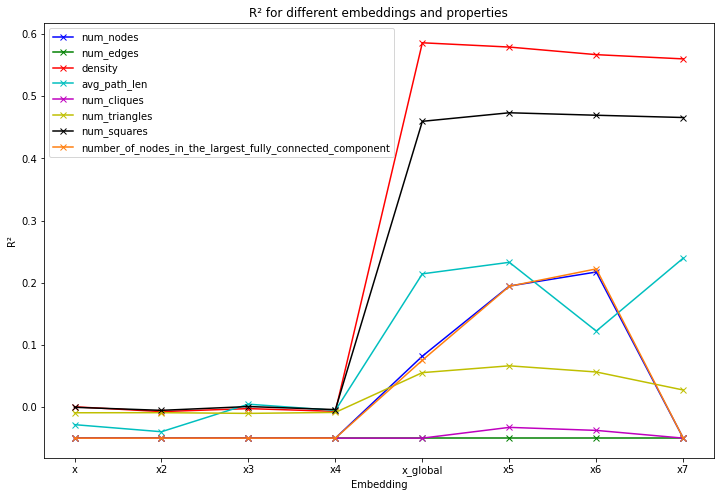

<Figure size 432x288 with 0 Axes>

In [16]:
#load results 
with open("results/"+DATASET+"_"+MODEL+"_results.pkl", "rb") as f:
    results = pkl.load(f)
import matplotlib.pyplot as plt

# Assuming results, embeddings, and other necessary variables are defined as in your context
property_names = ['num_nodes', 'num_edges', 'density', 'avg_path_len', 'num_cliques', 'num_triangles', 'num_squares', 'number_of_nodes_in_the_largest_fully_connected_component']
embeddings = [(train_x, test_x), (train_x2, test_x2), (train_x3, test_x3), (train_x4, test_x4), (train_x_global, test_x_global), (train_x5, test_x5), (train_x6, test_x6), (train_x7, test_x7)]
embeddings_names = ['x', 'x2', 'x3', 'x4', 'x_global', 'x5', 'x6', 'x7']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:purple']

plt.figure(figsize=(12, 8))

for i, property_name in enumerate(property_names):
    x_points = []
    y_points = []
    for j, embedding in enumerate(embeddings):
        name_of_embedding = embeddings_names[j]
        test_r2 = results[(name_of_embedding, property_name)][3]
        if test_r2 < -0.05:  # Handle negative R² values
            test_r2 = -0.05
        x_points.append(j)
        y_points.append(test_r2)
    
    # Plotting the line for the current property
    plt.plot(x_points, y_points, label=property_name, color=colors[i], marker='x')

plt.xticks(range(len(embeddings)), embeddings_names)
plt.xlabel('Embedding')
plt.ylabel('R²')
plt.legend()
plt.title('R² for different embeddings and properties')
plt.show()

#save the plot
plt.savefig('results/'+DATASET+'_'+MODEL+'_test_R2_plot.png', dpi=300, bbox_inches='tight')

### Node embedding probing

This time we will try to probe for node embedding learnt representations. What would make sense is that the GNN uses some node characteristics like the betweeness centrality of some nodes to predict if a graph could contain both a grid and a house. 


/!\ Try to not forget that we need to change the batch_size to 1 if we want to probe for node properties as we need the forward pass to be made 1 graph by 1 graph at a time. 

##### Node properties

In [11]:
# Define function to compute node-level properties
def compute_node_properties(data):
    properties = []
    for graph_data in data:
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        node_degrees = list(dict(G.degree()).values())
        clustering_coeffs = list(nx.clustering(G).values())
        betweenness_centralities = list(nx.betweenness_centrality(G).values())
        eigenvector_centralities = list(nx.eigenvector_centrality(G, max_iter=10000).values())
        Local_clustering_coefficients = list(nx.clustering(G).values())

        properties.append((node_degrees, clustering_coeffs, betweenness_centralities, eigenvector_centralities, Local_clustering_coefficients))
    return properties

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset[gnn.train_idx])
test_node_properties = compute_node_properties(gnn.dataset[gnn.test_idx])

#train_node_properties is a list of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph

In [12]:
len(train_node_properties), len(test_node_properties)

(1600, 400)

In [13]:
# Check the length of the first three betweenness centralities of the three first graphs in the train set
[len(train_node_properties[i][2]) for i in range(3)]

[25, 27, 27]

We see that for each graph, the length of the betweenness centralities, and in general the length of properties, are equal to the number of nodes in the graph and thus
is equal to the length of the x matrix in the features. 

([6, 3, 1, 3, 1, 2, 1, 1, 1, 2, 2, 3, 1, 3, 2, 3, 3, 2, 3, 3, 2, 4, 3, 2, 3, 2], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.3333333333333333, 0.3333333333333333, 1.0, 0, 0, 0, 0, 0, 0, 0, 0], [0.5333333333333333, 0.15666666666666668, 0.0, 0.68, 0.0, 0.08, 0.0, 0.0, 0.0, 0.48000000000000004, 0.33333333333333337, 0.45777777777777784, 0.0, 0.2816666666666667, 0.03666666666666667, 0.11, 0.005, 0.0, 0.18666666666666665, 0.18666666666666665, 0.03277777777777778, 0.1488888888888889, 0.045000000000000005, 0.03277777777777778, 0.045000000000000005, 0.0044444444444444444], [0.10521234016833964, 0.048588000626310864, 0.03673891466296968, 0.1006609369854998, 0.03673891466296968, 0.041840717455278266, 0.03673891466296968, 0.016966456417454732, 0.016966456417454732, 0.13788238057672458, 0.04518201359998669, 0.29421941246853595, 0.014610350065082807, 0.028731959419011167, 0.016198792919026577, 0.020900550098289828, 0.017656811386470742, 0.013464259755574791, 0.3523681982355651, 0.352368198235565

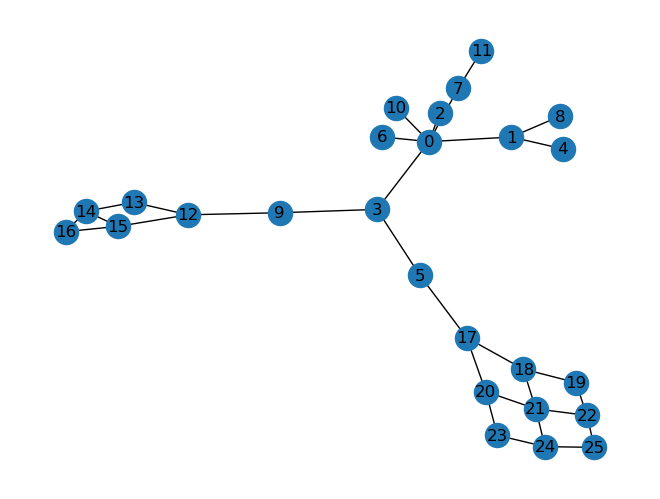

In [14]:
#visualise the first graph of the test set to see if the properties are correct
G = nx.from_edgelist(gnn.dataset[gnn.test_idx][0].edge_index.t().tolist())
nx.draw(G, with_labels=True)

#print the properties of the first graph
print(test_node_properties[0])

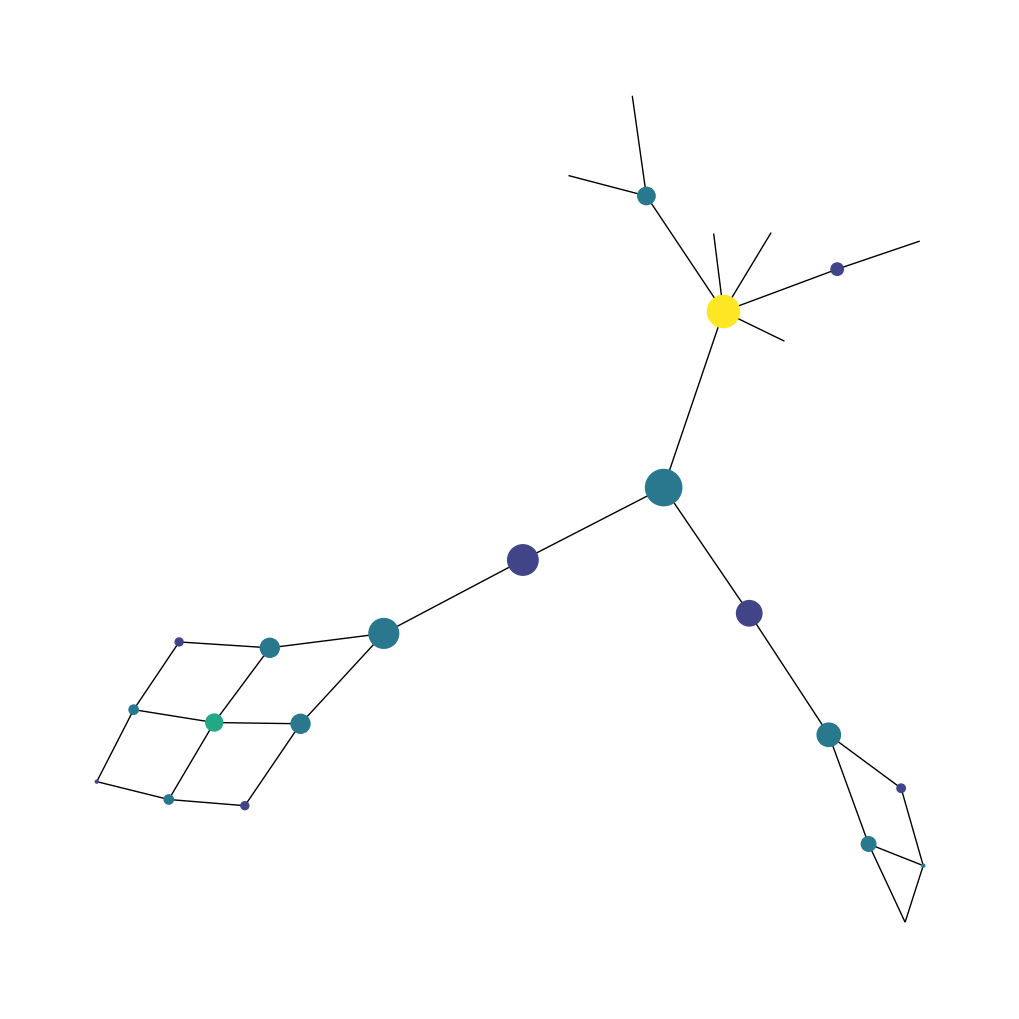

In [15]:
#represent the properties of betweenness centrality on the graph by chaging the size of the nodes
betweenness_centrality = test_node_properties[0][2]
node_degrees = test_node_properties[0][0]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=[v * 1000 for v in betweenness_centrality], node_color=node_degrees, cmap='viridis')
plt.show()


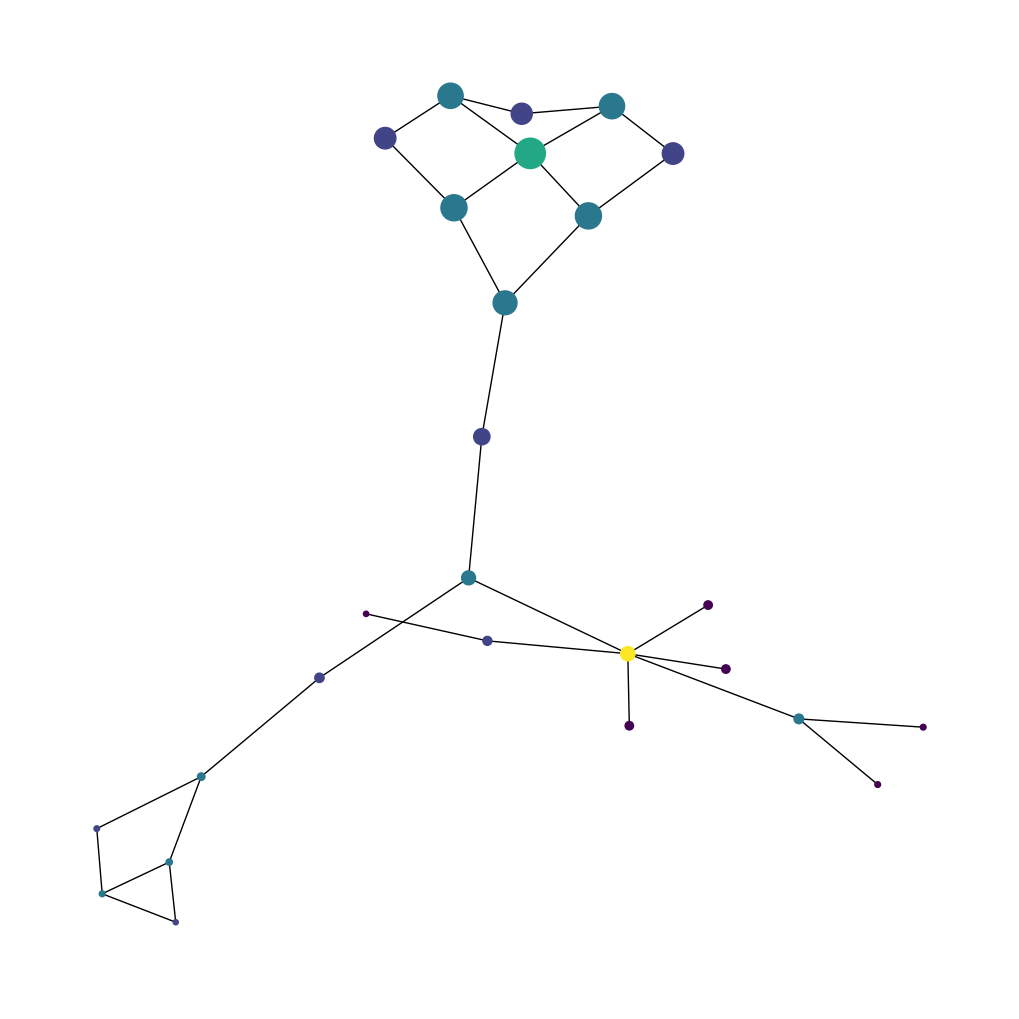

In [16]:
#same for eigenvector centrality
eigenvector_centralities = test_node_properties[0][3]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=[v * 1000 for v in eigenvector_centralities], node_color=node_degrees, cmap='viridis')
plt.show()

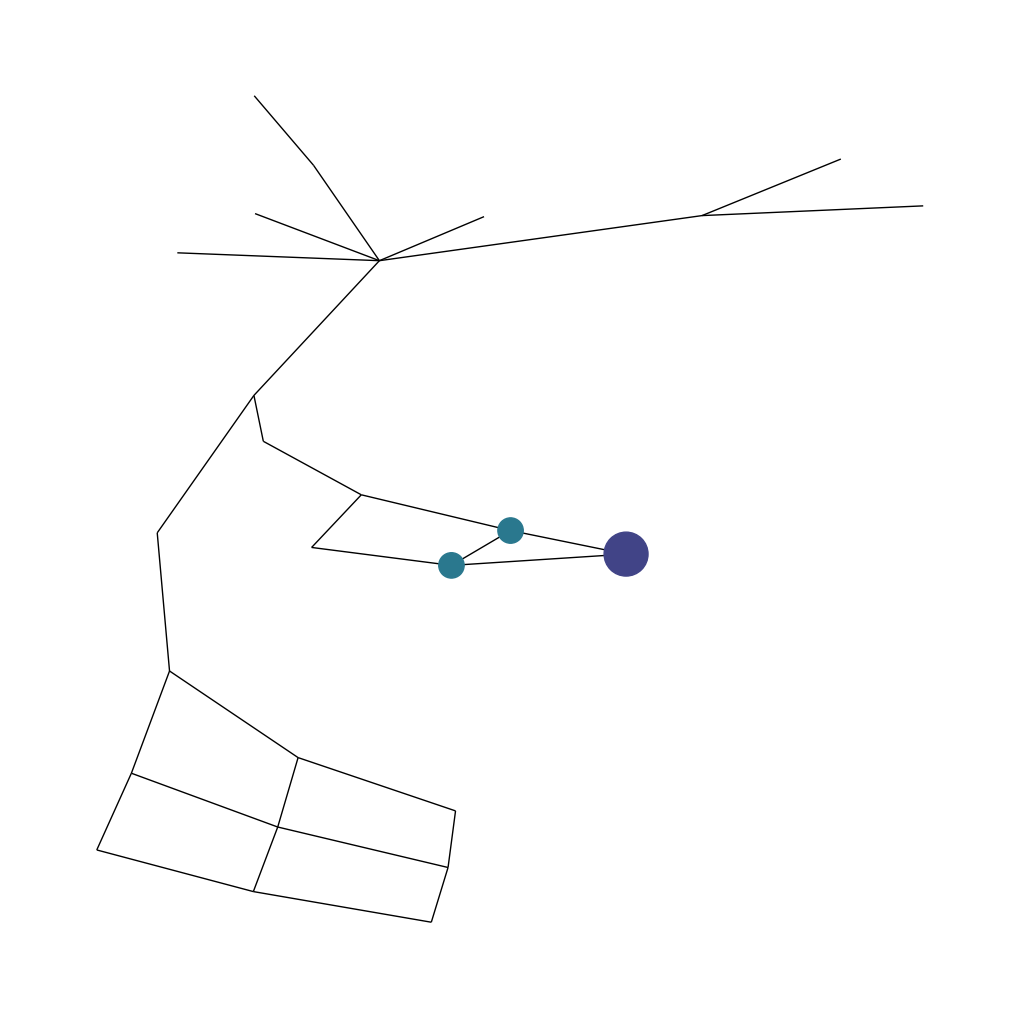

In [17]:
#same for local clustering coefficients
Local_clustering_coefficients = test_node_properties[0][4]

plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=[v * 1000 for v in Local_clustering_coefficients], node_color=node_degrees, cmap='viridis')
plt.show()

Hypothesis : it would make a lot of sense for the GNN to use both the node propeties of local clustering coefficient and eigenvector centrality. The interesting thing is that these two features individually are not enough to render the problem linearly separable. It would thus make sense to use both of these properties and combine them. At the end, the problem makes more sense to be solved in a global property fashion with the number of squares. 
But if it makes sense to use these node properties for the classification of the double presence of grid and house, then we should be able to probe them in the node embeddings. In other words, if we can rpedict some node-level property on the corresponding vector embeddings of the GNN for a given classification problem, then it should mean that these properties are useful for the problem resolution.

For example, if the local clustreing coefficient of a node is an important feature for prediciton, we should then see that we can consistently preidct it throught the layers for graphs. We could try for both the node of interest (first find the node of interest (the max value), then its position and probe only for the corresponding vector). The given prediction score would be a good indicator of the use of this property *and* we could give a designed graph that shows the relation between the property values and the ability to predict it. Or for all the nodes (even those with a value of 0 for example), and present the average score as a good indicator (meaning that it's important for the GNN to be able to predict when the property is not here. That's also something that could work). 

We have our node embeddings (Train and test features) are lists of lists. Each element correspond to a graph, each graph has 8 layers of features, and each features has a shape of (num_nodes, num_features) where each row is a node and each column is a feature. As a consequence the number of nodes in the graph is changing for each graph.

Same with node_properties, train and test_node_properties are lists of tuples, where each tuple contains 5 lists, each list contains the node-level property for each node in the graph. 

Because they have the same inconsistencies (graph are presented in the same order and thus if the first one has 24 nodes and the second 27, both embeddings and properties will correspond), then we can have a probe one by one.

##### Node embeddings

In [10]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

x1 shape: torch.Size([25, 60])
x2 shape: torch.Size([25, 60])
x3 shape: torch.Size([25, 60])
x4 shape: torch.Size([25, 60])
len of features:  4
features[0].shape:  torch.Size([25, 60])
features[1].shape:  torch.Size([25, 60])
features[2].shape:  torch.Size([25, 60])
features[3].shape:  torch.Size([25, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])


In [11]:
len(train_features), len(test_features)

(1600, 400)

In [18]:
# Check the shape of the first graph's features
first_graph_features = train_features[1]
for i, feature in enumerate(first_graph_features):
    print(f"Feature {i+1} shape:", feature.shape)

Feature 1 shape: (27, 60)
Feature 2 shape: (27, 60)
Feature 3 shape: (27, 60)
Feature 4 shape: (27, 60)


In [22]:
train_features[1][0][26]

array([0.11293012, 0.01297014, 0.        , 0.        , 0.00048169,
       0.        , 0.        , 0.11032721, 0.0006601 , 0.        ,
       0.        , 0.00569319, 0.01119991, 0.        , 0.        ,
       0.        , 0.        , 0.1187728 , 0.02496059, 0.        ,
       0.        , 0.        , 0.09984584, 0.        , 0.16730181,
       0.12269668, 0.        , 0.        , 0.13658862, 0.        ,
       0.        , 0.        , 0.        , 0.02736452, 0.        ,
       0.        , 0.        , 0.01627633, 0.        , 0.00716374,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.11217522, 0.00050629, 0.        , 0.04717182,
       0.11243994, 0.        , 0.        , 0.        , 0.06470888,
       0.        , 0.        , 0.        , 0.        , 0.        ])

#### Embedding probing

##### Probing for the top 3 nodes on train_features only and averaging the results of the different diagnostif classifiers

In [58]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Function to get the top 3 nodes based on a specific property
def get_top_nodes(property_list, top_n=3):
    sorted_indices = sorted(range(len(property_list)), key=lambda k: property_list[k], reverse=True)
    return sorted_indices[:top_n]

In [59]:

# Get the top 3 nodes for local clustering coefficient and eigenvector centrality
top_nodes_local_clustering = [get_top_nodes(graph_props[3], 3) for graph_props in train_node_properties]  # Assuming 3rd index is for local clustering coefficient
top_nodes_eigenvector = [get_top_nodes(graph_props[4], 3) for graph_props in train_node_properties]  # Assuming 4th index is for eigenvector centrality


In [60]:
# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, top_nodes_indices):
    X = []
    y = []
    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices[i]:
                X.append(graph_features[layer][node_index])
                y.append(properties[i][node_index])
    return torch.tensor(X), torch.tensor(y)

# Training and evaluating linear regression models
def train_and_evaluate_regression(X, y):
    model = LinearModel(X.shape[1], 1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Train the model
    model.train()
    for epoch in range(1000):
        optimizer.zero_grad()
        outputs = model(X.float())
        loss = criterion(outputs, y.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        predictions = model(X.float()).view(-1)
        r2 = r2_score(y.float(), predictions)
    return r2

In [69]:

# Prepare data for local clustering coefficient regression
X_local_clustering, y_local_clustering = prepare_regression_data(train_features, [props[3] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for local clustering coefficient
r2_local_clustering = train_and_evaluate_regression(X_local_clustering, y_local_clustering)
print(f'R² for local clustering coefficient prediction: {r2_local_clustering}')

# Prepare data for eigenvector centrality regression
X_eigenvector, y_eigenvector = prepare_regression_data(train_features, [props[4] for props in train_node_properties], top_nodes_eigenvector)

# Train and evaluate model for eigenvector centrality
r2_eigenvector = train_and_evaluate_regression(X_eigenvector, y_eigenvector)
print(f'R² for eigenvector centrality prediction: {r2_eigenvector}')

# Prepare data for node degree regression
X_node_degree, y_node_degree = prepare_regression_data(train_features, [props[0] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for node degree
r2_node_degree = train_and_evaluate_regression(X_node_degree, y_node_degree)
print(f'R² for node degree prediction: {r2_node_degree}')

# Prepare data for betweenness centrality regression
X_betweenness, y_betweenness = prepare_regression_data(train_features, [props[2] for props in train_node_properties], top_nodes_local_clustering)

# Train and evaluate model for betweenness centrality
r2_betweenness = train_and_evaluate_regression(X_betweenness, y_betweenness)
print(f'R² for betweenness centrality prediction: {r2_betweenness}')


R² for local clustering coefficient prediction: [0.4841927549025531, 0.5885748736985221, 0.553935958537314, 0.5937347910192293]
R² for eigenvector centrality prediction: [0.4159696190840295, 0.4910735740692913, 0.5317800215207991, 0.5328035947641372]
R² for node degree prediction: [0.79121277530391, 0.813389031323898, 0.7947223264111095, 0.805799508393025]
R² for betweenness centrality prediction: [0.49523594279566274, 0.53993553609594, 0.5741994943077879, 0.5884060368158552]


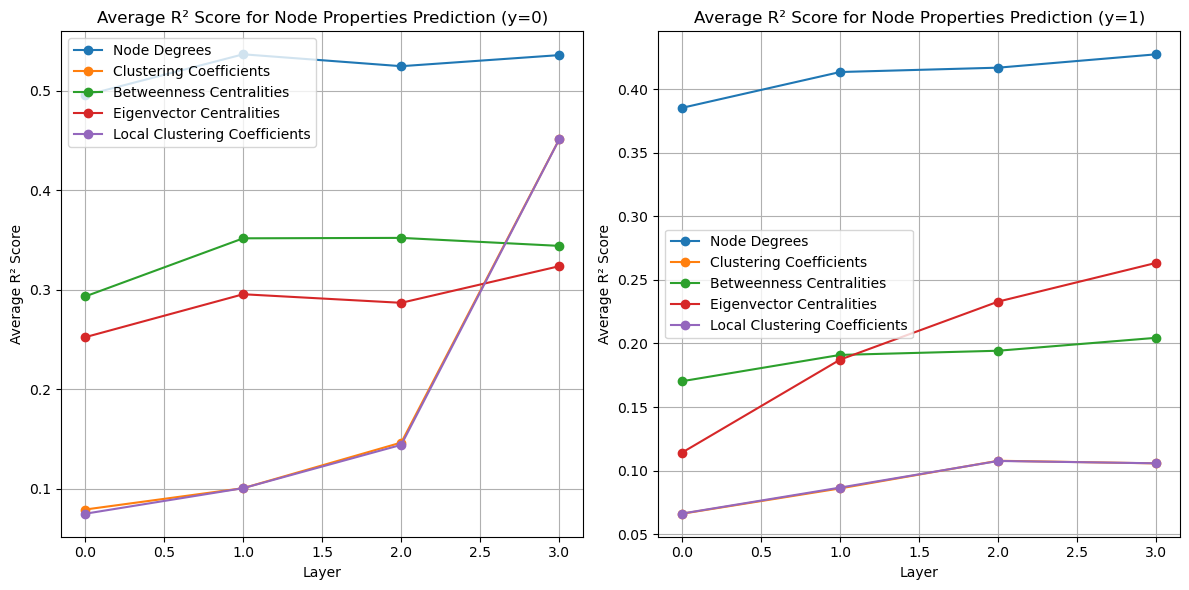

In [67]:
# Separate the graphs based on labels
def separate_graphs_by_label(features, properties, labels):
    features_0, properties_0, features_1, properties_1 = [], [], [], []
    
    for i, graph in enumerate(gnn.dataset[gnn.train_idx]):
        if graph.y.item() == 0:
            features_0.append(features[i])
            properties_0.append(properties[i])
        else:
            features_1.append(features[i])
            properties_1.append(properties[i])
    
    return features_0, properties_0, features_1, properties_1

train_features_0, train_properties_0, train_features_1, train_properties_1 = separate_graphs_by_label(train_features, train_node_properties, gnn.dataset[gnn.train_idx])

# Prepare the data for linear regression model training
def prepare_regression_data(features, properties, property_index):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        for layer in range(len(graph_features)):
            for node_index in range(len(graph_features[layer])):
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Training and evaluating linear regression models for each layer
def train_and_evaluate_regression(X_layers, y_layers):
    r2_scores = []
    
    for layer in range(len(X_layers)):
        X = X_layers[layer]
        y = y_layers[layer]
        
        model = LinearModel(X.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X.float())
            loss = criterion(outputs, y.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions = model(X.float()).view(-1)
            r2 = r2_score(y.float(), predictions)
        r2_scores.append(r2)
    
    return r2_scores

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients

properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store R² scores
r2_scores_0 = {name: [] for name in property_names}
r2_scores_1 = {name: [] for name in property_names}

# Compute R² scores for graphs with y=0
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_0, train_properties_0, prop_idx)
    r2_scores_0[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Compute R² scores for graphs with y=1
for prop_idx, prop_name in zip(properties_indices, property_names):
    X_layers, y_layers = prepare_regression_data(train_features_1, train_properties_1, prop_idx)
    r2_scores_1[prop_name] = train_and_evaluate_regression(X_layers, y_layers)

# Plot the results
layers = np.arange(len(r2_scores_0[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for graphs with y=0
plt.subplot(1, 2, 1)
for prop_name in property_names:
    plt.plot(layers, r2_scores_0[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=0)')
plt.legend()
plt.grid(True)

# Plot for graphs with y=1
plt.subplot(1, 2, 2)
for prop_name in property_names:
    plt.plot(layers, r2_scores_1[prop_name], label=prop_name, marker='o')
plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction (y=1)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

##### Probing for the top 1 nodes with diagnostic classifier trained on the train set and test on the test set

Processing property: Node Degrees
Processing property: Clustering Coefficients
Processing property: Betweenness Centralities
Processing property: Eigenvector Centralities
Processing property: Local Clustering Coefficients


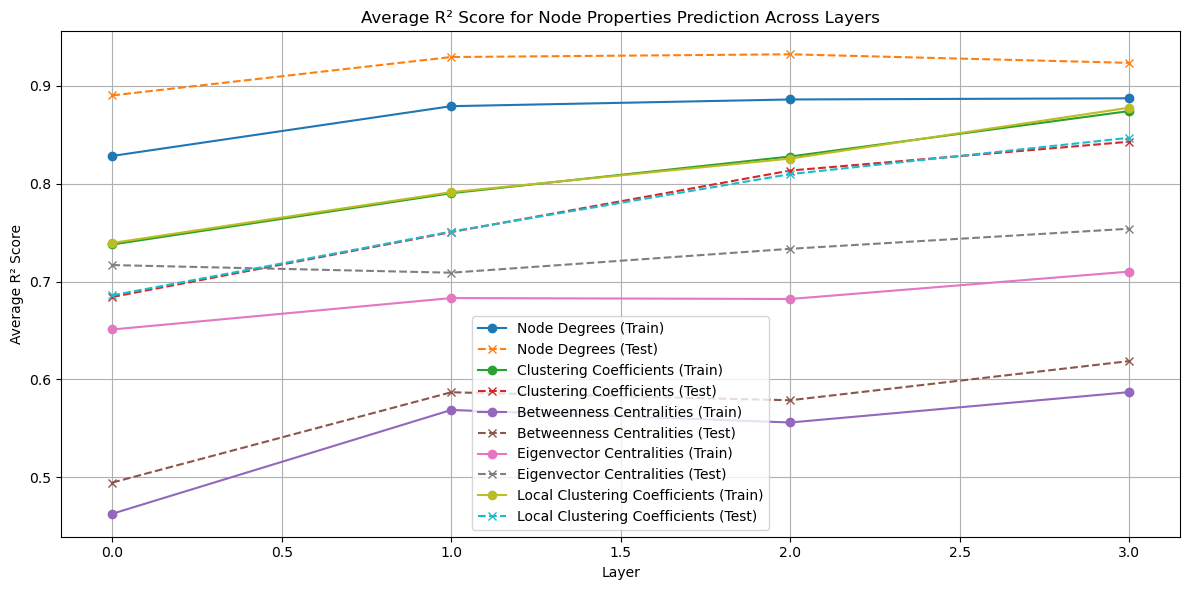

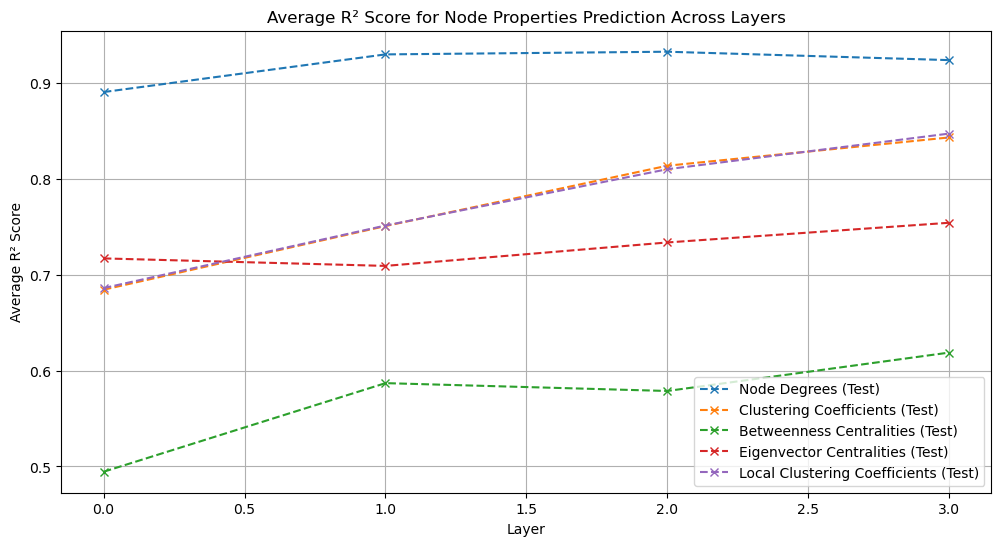

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np

# Define Linear Model for probing (diagnostic classifier)
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Prepare the data for probing classifier
def prepare_regression_data(features, properties, property_index, top_n_nodes=1):
    X_layers = [[] for _ in range(len(features[0]))]
    y_layers = [[] for _ in range(len(features[0]))]

    for i, graph_features in enumerate(features):
        top_nodes_indices = get_top_nodes(properties[i][property_index], top_n=top_n_nodes)
        for layer in range(len(graph_features)):
            for node_index in top_nodes_indices:
                X_layers[layer].append(graph_features[layer][node_index])
                y_layers[layer].append(properties[i][property_index][node_index])

    X_layers = [torch.tensor(X) for X in X_layers]
    y_layers = [torch.tensor(y) for y in y_layers]
    
    return X_layers, y_layers

# Train and evaluate the probing classifier for each layer
def train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers):
    r2_scores_train = []
    r2_scores_test = []
    
    for layer in range(len(X_train_layers)):
        X_train = X_train_layers[layer]
        y_train = y_train_layers[layer]
        X_test = X_test_layers[layer]
        y_test = y_test_layers[layer]
        
        model = LinearModel(X_train.shape[1], 1)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        
        # Train the model
        model.train()
        for epoch in range(10000):
            optimizer.zero_grad()
            outputs = model(X_train.float())
            loss = criterion(outputs, y_train.float().view(-1, 1))
            loss.backward()
            optimizer.step()
        
        # Evaluate the model
        model.eval()
        with torch.no_grad():
            predictions_train = model(X_train.float()).view(-1)
            predictions_test = model(X_test.float()).view(-1)
            r2_train = r2_score(y_train.float(), predictions_train)
            r2_test = r2_score(y_test.float(), predictions_test)
        r2_scores_train.append(r2_train)
        r2_scores_test.append(r2_test)
    
    return r2_scores_train, r2_scores_test

# Aggregate R² scores across all graphs
def aggregate_r2_scores(features_train, properties_train, features_test, properties_test, property_index):
    X_train_layers, y_train_layers = prepare_regression_data(features_train, properties_train, property_index)
    X_test_layers, y_test_layers = prepare_regression_data(features_test, properties_test, property_index)
    
    r2_scores_train, r2_scores_test = train_and_evaluate_regression(X_train_layers, y_train_layers, X_test_layers, y_test_layers)
    
    return r2_scores_train, r2_scores_test

# Properties indices: 0 - node_degrees, 1 - clustering_coeffs, 2 - betweenness_centralities, 3 - eigenvector_centralities, 4 - Local_clustering_coefficients
properties_indices = [0, 1, 2, 3, 4]
property_names = ['Node Degrees', 'Clustering Coefficients', 'Betweenness Centralities', 'Eigenvector Centralities', 'Local Clustering Coefficients']

# Initialize dictionaries to store average R² scores across all layers
avg_r2_train_dict = {name: [] for name in property_names}
avg_r2_test_dict = {name: [] for name in property_names}

# Train and evaluate the probing classifier for each property
for prop_idx, prop_name in zip(properties_indices, property_names):
    print(f"Processing property: {prop_name}")
    avg_r2_train_dict[prop_name], avg_r2_test_dict[prop_name] = aggregate_r2_scores(train_features, train_node_properties, test_features, test_node_properties, prop_idx)

# Plotting the average R² scores across layers for each property
layers = np.arange(len(avg_r2_train_dict[property_names[0]]))

plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_train_dict[prop_name], label=f'{prop_name} (Train)', marker='o')
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

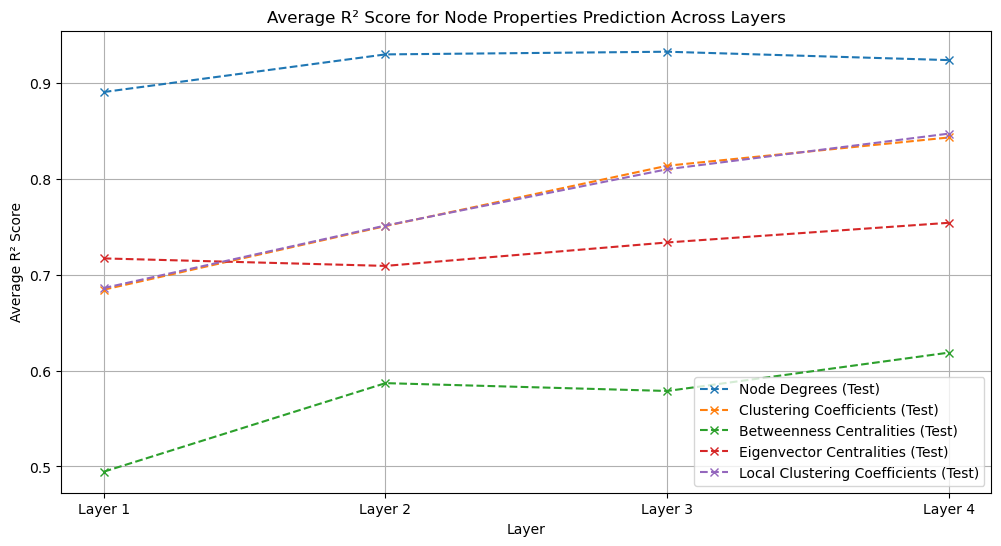

In [81]:
#plot only test results
plt.figure(figsize=(12, 6))

# Plot for average R² scores
for prop_name in property_names:
    plt.plot(layers, avg_r2_test_dict[prop_name], label=f'{prop_name} (Test)', linestyle='--', marker='x')

plt.xlabel('Layer')
plt.ylabel('Average R² Score')
plt.title('Average R² Score for Node Properties Prediction Across Layers')
plt.legend()
#x axis called layer 1, layer 2, etc
plt.xticks(range(len(layers)), [f'Layer {i+1}' for i in layers])           
plt.grid(True)

## Probing for all nodes using another method

### Node Properties 

In [13]:
import networkx as nx
import torch

def compute_node_properties(data, indices):
    properties = []
    for idx in indices:
        graph_data = data[idx]
        G = nx.from_edgelist(graph_data.edge_index.t().tolist())
        
        # Calculate node properties using NetworkX
        degree = dict(G.degree())
        clustering = nx.clustering(G)
        betweenness = nx.betweenness_centrality(G)
        closeness = nx.closeness_centrality(G)
        eigenvector = nx.eigenvector_centrality(G, max_iter=10000)
        pagerank = nx.pagerank(G)
        
        # Store properties for each node in the graph
        node_properties = []
        for node in G.nodes():
            node_properties.append({
                'degree': degree[node],
                'clustering': clustering[node],
                'betweenness': betweenness[node],
                'closeness': closeness[node],
                'eigenvector': eigenvector[node],
                'pagerank': pagerank[node]
            })

        properties.append(node_properties)
    return properties

# Ensure gnn.train_idx and gnn.test_idx are lists of integers
train_idx = gnn.train_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.train_idx
test_idx = gnn.test_idx.tolist() if isinstance(gnn.train_idx, torch.Tensor) else gnn.test_idx

# Compute node-level properties for train and test sets
train_node_properties = compute_node_properties(gnn.dataset, train_idx)
test_node_properties = compute_node_properties(gnn.dataset, test_idx)


### Features

In [14]:
train_features, test_features = gnn.evaluate_with_features2(return_node_embeddings=True)

x1 shape: torch.Size([25, 60])
x2 shape: torch.Size([25, 60])
x3 shape: torch.Size([25, 60])
x4 shape: torch.Size([25, 60])
len of features:  4
features[0].shape:  torch.Size([25, 60])
features[1].shape:  torch.Size([25, 60])
features[2].shape:  torch.Size([25, 60])
features[3].shape:  torch.Size([25, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])
train_features[0][0].shape:  (25, 60)
x1 shape: torch.Size([27, 60])
x2 shape: torch.Size([27, 60])
x3 shape: torch.Size([27, 60])
x4 shape: torch.Size([27, 60])
len of features:  4
features[0].shape:  torch.Size([27, 60])
features[1].shape:  torch.Size([27, 60])
features[2].shape:  torch.Size([27, 60])
features[3].shape:  torch.Size([27, 60])


In [15]:
print(len(train_node_properties))
print(len(train_node_properties[0]))
print(train_node_properties[0][0])

1600
25
{'degree': 4, 'clustering': 0, 'betweenness': 0.2391304347826087, 'closeness': 0.24242424242424243, 'eigenvector': 0.033186324974026786, 'pagerank': 0.08190300503512479}


### Linear classifier

**Probe**

Example data structure for multiple graphs

train_features: List of graphs, each with multiple layers of features

```plaintext
train_features = [
    [np.array([...]), np.array([...]), ...],  # Graph 1: features for each layer
    [np.array([...]), np.array([...]), ...],  # Graph 2: features for each layer
    ...
]
```
train_node_properties: List of graphs, each with a list of node properties

```plaintext
train_node_properties = [
    [{'degree': ..., 'clustering': ..., ...}, {'degree': ..., ...}, ...],  # Graph 1: properties for each node
    [{'degree': ..., 'clustering': ..., ...}, {'degree': ..., ...}, ...],  # Graph 2: properties for each node
    ...
]
```
test_features and test_node_properties would be similarly structured for the test set

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

class LinearModel(nn.Module):
    def __init__(self, input_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return self.linear(x)

In [17]:
def train_probe_for_layer(features, property_values, test_features, test_property_values, num_epochs=10000, learning_rate=0.01):
    # Convert features and property values to PyTorch tensors if they are NumPy arrays
    if isinstance(features, np.ndarray):
        features = torch.tensor(features, dtype=torch.float32)
    if isinstance(property_values, np.ndarray):
        property_values = torch.tensor(property_values, dtype=torch.float32)

    if isinstance(test_features, np.ndarray):
        test_features = torch.tensor(test_features, dtype=torch.float32)
    if isinstance(test_property_values, np.ndarray):
        test_property_values = torch.tensor(test_property_values, dtype=torch.float32)

    print(f"Training on features with shape: {features.shape} for property values shape: {property_values.shape}")

    model = LinearModel(features.shape[1])  # Features should be 2D: (num_nodes, feature_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(features).squeeze()  # Remove single-dimensional entries
        loss = criterion(output, property_values)
        loss.backward()
        optimizer.step()

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        pred = model(test_features).squeeze()
        mse = criterion(pred, test_property_values).item()
        # Flatten the tensors for proper use of r2_score
        r2 = r2_score(test_property_values.cpu().numpy(), pred.cpu().numpy())

    return mse, r2

Where inspiring from the techniques developped in AIFB probing for one graph : to handle multiple graphs, we choose the option :



In [18]:
def evaluate_layer_probes_across_graphs(train_features_list, test_features_list, train_properties_list, test_properties_list):
    num_layers = len(train_features_list[0])  # Assuming all graphs have the same number of layers
    results = []

    num_test_graphs = len(test_features_list)  # Number of graphs in the test set

    for layer_idx in range(num_layers):
        combined_train_features = []
        combined_test_features = []
        combined_train_properties = []
        combined_test_properties = []

        # Aggregate features and properties across all graphs
        for graph_idx in range(len(train_features_list)):
            combined_train_features.append(np.vstack(train_features_list[graph_idx][layer_idx]))

            # Use modulo to cycle through the test graphs
            test_idx = graph_idx % num_test_graphs
            combined_test_features.append(np.vstack(test_features_list[test_idx][layer_idx]))

            combined_train_properties.extend(train_properties_list[graph_idx])
            combined_test_properties.extend(test_properties_list[test_idx])

        combined_train_features = np.vstack(combined_train_features)  # Combine features across graphs
        combined_test_features = np.vstack(combined_test_features)

        # Train and evaluate probe for each property across all graphs
        for property_name in combined_train_properties[0].keys():  # Assuming all nodes have the same properties
            train_property_values = np.array([node[property_name] for node in combined_train_properties])
            test_property_values = np.array([node[property_name] for node in combined_test_properties])

            mse, r2 = train_probe_for_layer(combined_train_features, train_property_values, combined_test_features, test_property_values)
            
            results.append({
                'layer': layer_idx,
                'property': property_name,
                'mse': mse,
                'r2': r2
            })

    return results


In [19]:
results_across_graphs = evaluate_layer_probes_across_graphs(train_features, test_features, train_node_properties, test_node_properties)

#save the results in a file
import pickle as pkl
with open("results/"+DATASET+"_"+MODEL+"_results_across_graphs.pkl", "wb") as f:
    pkl.dump(results_across_graphs, f)

Training on features with shape: torch.Size([39060, 60]) for property values shape: torch.Size([39060])
Training on features with shape: torch.Size([39060, 60]) for property values shape: torch.Size([39060])
Training on features with shape: torch.Size([39060, 60]) for property values shape: torch.Size([39060])
Training on features with shape: torch.Size([39060, 60]) for property values shape: torch.Size([39060])
Training on features with shape: torch.Size([39060, 60]) for property values shape: torch.Size([39060])
Training on features with shape: torch.Size([39060, 60]) for property values shape: torch.Size([39060])
Training on features with shape: torch.Size([39060, 60]) for property values shape: torch.Size([39060])
Training on features with shape: torch.Size([39060, 60]) for property values shape: torch.Size([39060])
Training on features with shape: torch.Size([39060, 60]) for property values shape: torch.Size([39060])
Training on features with shape: torch.Size([39060, 60]) for pro

In [ ]:
#load the results
with open("results/"+DATASET+"_"+MODEL+"_results_across_graphs.pkl", "rb") as f:
    results_across_graphs = pkl.load(f)

In [20]:
import pickle as pkl
import matplotlib.pyplot as plt
def plot_results_across_graphs(results):
    layers = sorted(set(result['layer'] for result in results))
    properties = sorted(set(result['property'] for result in results))
    
    plt.figure(figsize=(12, 6))  # Increase the figure size for better readability
    
    for property_name in properties:
        r2_scores = []
        for layer in layers:
            layer_results = [r for r in results if r['layer'] == layer and r['property'] == property_name]
            # Calculate mean R² score for the layer
            mean_r2 = np.mean([r['r2'] for r in layer_results])
            # Set any R² value below -0.05 to -0.05
            if mean_r2 < -0.05:
                mean_r2 = -0.05
            r2_scores.append(mean_r2)
        
        # Plot the R² scores with crosses and lines, one line per property across all graphs
        plt.plot(layers, r2_scores, marker='x', linestyle='-', label=property_name)

    plt.title('R² Scores Across Layers for Different Properties (Aggregated Across Graphs)')
    plt.xticks(layers, [f'Layer {i+1}' for i in layers])  # Set the x-axis labels to layer numbers
    plt.xlabel('Layer')
    plt.ylabel('R² Score')
    plt.legend()
    plt.grid(True)  # Add grid for better visibility of points and lines
    plt.show()

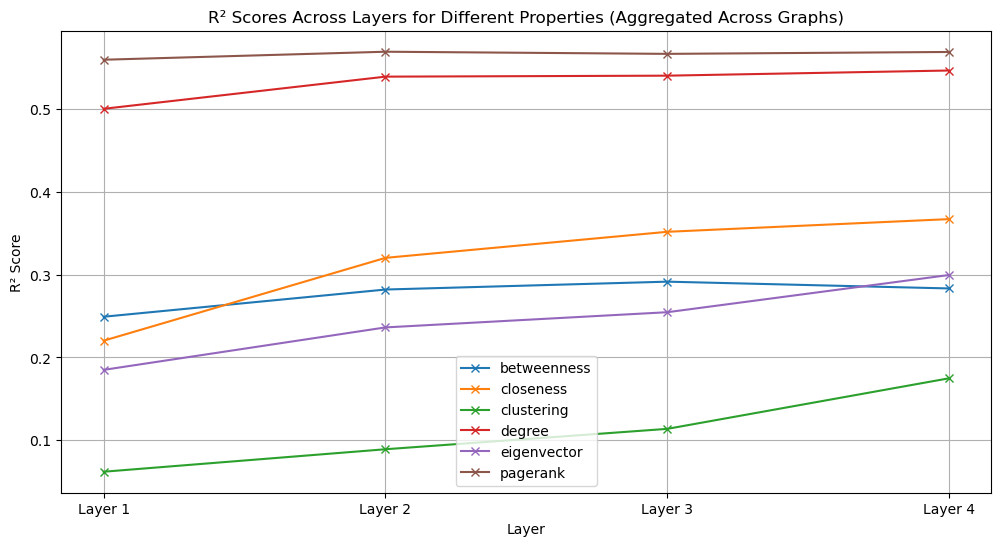

In [21]:
# Plot the results across all graphs
plot_results_across_graphs(results_across_graphs)

In [23]:
# Identify unique layers
layers = set(result['layer'] for result in results_across_graphs)

for layer in layers:
    # Filter results for the current layer
    layer_results = [result for result in results_across_graphs if result['layer'] == layer]
    
    # Extract and sort r2 values along with property names in descending order
    sorted_r2_values = sorted([(result['r2'], result['property']) for result in layer_results], reverse=True, key=lambda x: x[0])
    
    # Print the sorted r2 values with property names for the current layer
    print(f"Layer {layer}:")
    for r2, property in sorted_r2_values:
        print(f"  Property: {property}, R2: {r2}")
    print()  # Add a blank line for better readability

Layer 0:
  Property: pagerank, R2: 0.5597354889177619
  Property: degree, R2: 0.5004512605603075
  Property: betweenness, R2: 0.24918244458429373
  Property: closeness, R2: 0.22023728245049912
  Property: eigenvector, R2: 0.18498815299699356
  Property: clustering, R2: 0.061905781029651274

Layer 1:
  Property: pagerank, R2: 0.5694181656257427
  Property: degree, R2: 0.5393054222184839
  Property: closeness, R2: 0.32033455943232014
  Property: betweenness, R2: 0.282056622592188
  Property: eigenvector, R2: 0.23629102899195542
  Property: clustering, R2: 0.08906427806236428

Layer 2:
  Property: pagerank, R2: 0.5668255400267193
  Property: degree, R2: 0.540484331714293
  Property: closeness, R2: 0.3518231039522959
  Property: betweenness, R2: 0.2915676171056162
  Property: eigenvector, R2: 0.2546568488970792
  Property: clustering, R2: 0.11370536733638137

Layer 3:
  Property: pagerank, R2: 0.56912089343043
  Property: degree, R2: 0.5467214684222459
  Property: closeness, R2: 0.36715070